In [116]:
import glob
import random
import subprocess
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from rpy2.robjects import r
import rpy2.robjects as robjects
import matplotlib
%matplotlib inline
sns.set_style("ticks")

orange = sns.color_palette("Paired")[7]
blue = sns.color_palette("Paired")[1]
green = sns.color_palette("Paired")[3]
purple = sns.color_palette("Paired")[9]
red = sns.color_palette("Paired")[5]

interest_points = [
    3214,
    1432,
    1324,
    1342,
    3124,
    3142
]

def keep_interest(df):
    global interest_points
    return df[df["point_order"].isin(interest_points)]

my_orange = "#E65100"
my_blue = "#061f80"

def circled(x):
    return chr(0x245F+x)

grid_grey = "#e0e0e0"
grey = "#BDBDBD"
border_width = 0.5
threshold_line_width = .75
linewidth = 6.202 # linewidth from latex document
ts_green = "#3D8F24"
ts_purple = "#6E38CC"

fpath= "/System/Library/Fonts/Supplemental/Arial Unicode.ttf"
prop = matplotlib.font_manager.FontProperties(fname=fpath, size=8)

sns.set_context("paper", rc={"font.size": 8,
                             "axes.labelsize": 8,
                             "xtick.labelsize": 8,
                             "ytick.labelsize": 8,
                             "legend.fontsize": 8,
                             "legend.title_fontsize": 8,
                             "axes.linewidth": border_width}) 

In [3]:
col_names = ["event_no", "mfe", "gc", "has_n"]

cancer_df1 = pd.read_csv("mfe/cancer_mfes_ws50.tsv", sep="\t",
                     header=None, names=col_names)

random_df1 = pd.read_csv("mfe/random_mfes_ws50.tsv", sep="\t",
                        header=None, names=col_names)

In [6]:
event_no = cancer_df1["event_no"].unique()
random_event_no = random_df1["event_no"].unique()

In [7]:
canc_gc_dist = list(cancer_df1["mfe"])
rand_gc_dist = list(random_df1["mfe"])
all_gc = canc_gc_dist + rand_gc_dist
groups = ["canc"] * len(canc_gc_dist) + ["rand"] * len(rand_gc_dist)
all_mfe_df = pd.DataFrame(list(zip(groups, all_gc)),
                         columns =['label', 'mfe'])

In [36]:
mfe_dic = {}
with open("mfe/average_mfe_gcs.tsv", "r") as f:
    for i in f.readlines():
        i = i.rstrip().split("\t")
        gc = float(i[0])
        mfe = float(i[1])
        mfe_dic[gc] = mfe

In [37]:
regress_canc_p1_mfes = []
regress_random_p1_mfes = []

for i in event_no:
    sub_df = cancer_df1[cancer_df1["event_no"] == i]
    for i, row in sub_df.iterrows():
        if row["has_n"] == 1:
            sub_df.at[i,"mfe"] = np.NaN
        else:
            try:
                av_val = mfe_dic[row["gc"]]
                ifor_val = row["mfe"] - av_val
                sub_df.at[i,"mfe"] = ifor_val
            except KeyError:
                sub_df.at[i,"mfe"] = np.NaN
    regress_canc_p1_mfes.append(np.asarray(sub_df["mfe"].tolist())[:-1])


for i in random_event_no:
    sub_df = random_df1[random_df1["event_no"] == i]
    for i, row in sub_df.iterrows():
        if row["has_n"] == 1:
            sub_df.at[i,"mfe"] = np.NaN
        else:
            try:
                av_val = mfe_dic[row["gc"]]
                ifor_val = row["mfe"] - av_val
                sub_df.at[i,"mfe"] = ifor_val
            except KeyError:
                sub_df.at[i,"mfe"] = np.NaN
    regress_random_p1_mfes.append(np.asarray(sub_df["mfe"].tolist())[:-1])

In [24]:
canc_p1_mfes = []
random_p1_mfes = []

for i in event_no:
    sub_df = cancer_df1[cancer_df1["event_no"] == i]
    canc_p1_mfes.append(np.asarray(sub_df["mfe"].tolist())[:-1])

for i in random_event_no:
    sub_df = random_df1[random_df1["event_no"] == i]
    random_p1_mfes.append(np.asarray(sub_df["mfe"].tolist()))

In [46]:
def final_array(point_mfes):
    mfe_arr_final = []
    for i in point_mfes:
        if len(i) == 1001 or len(i) == 951:
            mfe_arr_final.append(i)
        if len(i) == 952:
            mfe_arr_final.append(i[1:])
        if len(i) == 950:
            mfe_arr_final.append(i)
    mfe_arr_final = np.asarray(mfe_arr_final)
    mfe_arr_final = mfe_arr_final.astype(np.float)
    return mfe_arr_final

In [64]:
cancer_final_array = final_array(regress_canc_p1_mfes)
random_final_array = final_array(regress_random_p1_mfes)

In [61]:
canc_p1 = np.nanmean(final_array(regress_canc_p1_mfes), axis=0)
rand_p1 = np.nanmean(final_array(regress_random_p1_mfes), axis=0)

canc_p1_std = np.nanpercentile(final_array(regress_canc_p1_mfes), 5, axis=0)

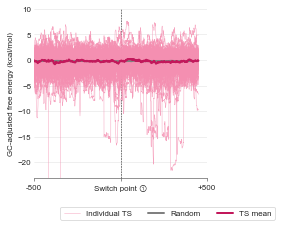

In [151]:
fig, ax = plt.subplots(figsize=(linewidth/2,linewidth/2))
ax.axvline(500, ls="--", lw=border_width, c="black", alpha=1)

for arr_i, arr in enumerate(cancer_final_array):
    if arr_i == len(cancer_final_array)-1:
        ax.plot(arr, lw=.5, color="#F48FB1", alpha=.8, label="Individual TS")
    else:
        ax.plot(arr, lw=.5, color="#F48FB1", alpha=.8)

ax.plot(rand_p1, lw=2, c="grey", label="Random")
ax.plot(canc_p1, lw=2, c="#C2185B", label="TS mean")

sns.despine(left=True)

ax.set_ylim(bottom=-23,top=10)

ax.set_xlim(0,1001)

ax.set_xticks(np.arange(0,1001,500))
ax.set_xticklabels([-500,"Switch point {}".format(circled(1)),"+500"], font=prop)

ax.tick_params(axis='y',
               which='both',
               length=0,
               width=border_width,
               pad=3)
ax.tick_params(axis='x',
               bottom=True,
               which='both',
               length=3,
               width=border_width)

ax.yaxis.grid(color="#e0e0e0",
                linewidth=border_width)

ax.set_ylabel("GC-adjusted free energy (kcal/mol)")

ax.legend(ncol=3, bbox_to_anchor=(.1282,-.15))

plt.savefig("cancer_mfe_signal.pdf", format="pdf", facecolor="white", bbox_inches="tight")